# Simple Consumption-Savings Model with Income Shocks and Credit Constraint alla Deaton

In [1]:
import io
import yaml
import pickle

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from src.solve import solve_egm
from src.consumption_savings_model import (
    utility_func_crra,
    marginal_utility_crra,
    inverse_marginal_utility_crra,
    compute_value_function,
    compute_next_period_wealth_matrix,
    compute_marginal_wealth_matrix
)

## 1) Specify *params* and *options*

In [2]:
params = """category,name,value,comment
beta,beta,0.95,discount factor
delta,delta,0,disutility of work
utility_function,theta,1,CRRA coefficient
wage,constant,0.75,age-independentlaborincome
wage,exp,0.04,return to experience
wage,exp_squared,-0.0004,return to experience squared
shocks,sigma,0.25,sigma parameter/standard deviation
assets,interest_rate,0.05,interest rate on capital
assets,initial_wealth_low,0,lowest level of inital wealth (relevant for simulation)
assets,initial_wealth_high,30,highest level of inital wealth (relevant for simulation)
assets,max_wealth,75,maximum level of wealth
assets,consumption_floor,0.001,consumption floor/retirement safety net (only relevant in the dc-egm retirement model)
"""

In [3]:
params = pd.read_csv(io.StringIO(params), index_col=["category", "name"])
params

value  \
category         name                           
beta             beta                  0.9500   
delta            delta                 0.0000   
utility_function theta                 1.0000   
wage             constant              0.7500   
                 exp                   0.0400   
                 exp_squared          -0.0004   
shocks           sigma                 0.2500   
assets           interest_rate         0.0500   
                 initial_wealth_low    0.0000   
                 initial_wealth_high  30.0000   
                 max_wealth           75.0000   
                 consumption_floor     0.0010   

                                                                                comment  
category         name                                                                    
beta             beta                                                   discount factor  
delta            delta                                               disutility of work  
utility_function theta                                                 CRRA coefficient  
wage             constant                                    age-independentlaborincome  
                 exp                                               return to experience  
                 exp_squared                               return to experience squared  
shocks           sigma                               sigma parameter/standard deviation  
assets           interest_rate                                 interest rate on capital  
                 initial_wealth_low   lowest level of inital wealth (relevant for si...  
                 initial_wealth_high  highest level of inital wealth (relevant for s...  
                 max_wealth                                     maximum level of wealth  
                 consumption_floor    consumption floor/retirement safety net (only ...

In [4]:
options = """n_periods: 25
min_age: 20
n_discrete_choices: 1
grid_points_wealth: 100
quadrature_points_stochastic: 10
n_simulations: 10
"""

In [5]:
options = yaml.safe_load(options)
options

{'n_periods': 25,
 'min_age': 20,
 'n_discrete_choices': 1,
 'grid_points_wealth': 100,
 'quadrature_points_stochastic': 10,
 'n_simulations': 10}

## 2) Solve via EGM

In [6]:
policy, value = solve_egm(
    params,
    options,
    utility_func_crra,
    marginal_utility_crra,
    inverse_marginal_utility_crra,
    compute_value_function,
    compute_next_period_wealth_matrix,
    compute_marginal_wealth_matrix
)

In [7]:
# Compare with expected results from MATLAB
TEST_RESOURCES_DIR = "tests/resources/"

policy_expected = pickle.load(open(TEST_RESOURCES_DIR + "policy_deaton.pkl", "rb"))
value_expected = pickle.load(open(TEST_RESOURCES_DIR + "value_deaton.pkl", "rb"))

np.testing.assert_allclose(policy[:24, ...], policy_expected)
np.testing.assert_allclose(value[:24, ...], value_expected)

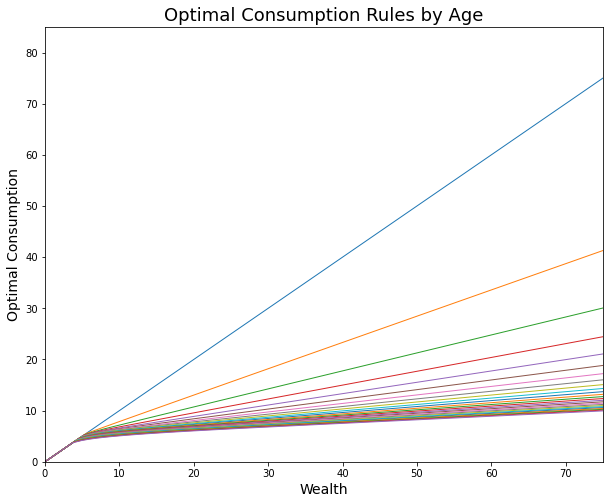

In [8]:
# plot
max_wealth = params.loc[("assets", "max_wealth"), "value"]
n_periods = options["n_periods"]

plt.rcParams["figure.figsize"] = (10,8)
plt.rcParams["axes.titlesize"] = 18
plt.rcParams["axes.labelsize"] = 14
# plt.rcParams["figure.figsize"] = plt.rcParamsDefault["figure.figsize"]

ax = plt.figure().add_subplot(111)


for period in range(n_periods - 1, -1, -1):
    
    ax.plot(policy[period, 0, 0, :], policy[period, 0, 1, :], linewidth=1)
    ax.set_xlim(0, max_wealth)
    ax.set_ylim(0, max_wealth + 10)
    
    ax.set_xlabel("Wealth")
    ax.set_ylabel("Optimal Consumption")
    ax.set_title("Optimal Consumption Rules by Age")
        
plt.show()

In [9]:
# The older the agent, the steeper (more positive) the curve (i.e. the more is consumed
# and the less is saved).

# Final period, everything consumed, nothing saved